In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os
import terra
import meerkat as mk
from domino.data.visual_genome import read_vg, ATTRIBUTE_GROUPS
import numpy as np
import pandas as pd
from rich import print
import sys
sys.path.insert(1,'/pd/maya/domino/domino')

In [7]:
#for p in sys.path:
#    print(p)

## MIMIC Slice Experiments

### Generate Slices

In [4]:
import slices.mimic

In [8]:
dataset_dir = '/pd/maya/mimic_dp_adjusted_diagnoses.mk'

In [135]:
target = 'lung_group'
correlate = 'pleural_group'

In [136]:
dp = slices.mimic.build_correlation_slice(target, correlate, 0.8, 1e4, dataset_dir)
dp.shape

(9998, 67)

In [137]:
print('target: ' + target + f'==1: {np.sum(dp[target]==1)}')
print('correlate: ' + correlate + f'==1: {np.sum(dp[correlate]==1)}')
print(f'{target}==1 and {correlate}==1: {np.sum((dp[correlate]==1) & (dp[target]==1))}')
print(f'{target}==0 and {correlate}==0: {np.sum((dp[correlate]==0) & (dp[target]==0))}')
print(f'{target}==1 and {correlate}==0: {np.sum((dp[correlate]==0) & (dp[target]==1))}')
print(f'{target}==0 and {correlate}==1: {np.sum((dp[correlate]==1) & (dp[target]==0))}')

target: lung_group==1: 2359

correlate: pleural_group==1: 2359

lung_group==1 and pleural_group==1: 1999

lung_group==0 and pleural_group==0: 7279

lung_group==1 and pleural_group==0: 360

lung_group==0 and pleural_group==1: 360

In [25]:
#import utils

In [26]:
#splits = utils.split_dp(dp, split_on="dicom_id")

,dicom_id (PandasSeriesColumn),study_id (PandasSeriesColumn),subject_id (PandasSeriesColumn),dicom_path (PandasSeriesColumn),gender (PandasSeriesColumn),anchor_age (PandasSeriesColumn),anchor_year (PandasSeriesColumn),anchor_year_group (PandasSeriesColumn),dod (PandasSeriesColumn),dicom (PandasSeriesColumn),study_date (PandasSeriesColumn),image_type (PandasSeriesColumn),table_type (PandasSeriesColumn),distance_source_to_detector (PandasSeriesColumn),distance_source_to_patient (PandasSeriesColumn),exposure (PandasSeriesColumn),exposure_time (PandasSeriesColumn),x_ray_tube_current (PandasSeriesColumn),field_of_view_rotation (PandasSeriesColumn),field_of_view_origin (PandasSeriesColumn),field_of_view_horizontal_flip (PandasSeriesColumn),view_position (PandasSeriesColumn),patient_orientation (PandasSeriesColumn),burned_in_annotation (PandasSeriesColumn),requesting_service (PandasSeriesColumn),detector_primary_angle (PandasSeriesColumn),detector_element_physical_size (PandasSeriesColumn),report_path (PandasSeriesColumn),hadm_id (PandasSeriesColumn),admittime (PandasSeriesColumn),dischtime (PandasSeriesColumn),deathtime (PandasSeriesColumn),admission_type (PandasSeriesColumn),admission_location (PandasSeriesColumn),discharge_location (PandasSeriesColumn),insurance (PandasSeriesColumn),language (PandasSeriesColumn),marital_status (PandasSeriesColumn),ethnicity (PandasSeriesColumn),edregtime (PandasSeriesColumn),edouttime (PandasSeriesColumn),hospital_expire_flag (PandasSeriesColumn),index (PandasSeriesColumn),jpg_path (PandasSeriesColumn),cxr_jpg (GCSImageColumn),cxr_dicom (GCSImageColumn),cxr_jpg_1024 (ImageColumn),atelectasis (PandasSeriesColumn),cardiomegaly (PandasSeriesColumn),consolidation (PandasSeriesColumn),edema (PandasSeriesColumn),enlarged_cardiomediastinum (PandasSeriesColumn),fracture (PandasSeriesColumn),lung_lesion (PandasSeriesColumn),lung_opacity (PandasSeriesColumn),no_finding (PandasSeriesColumn),pleural_effusion (PandasSeriesColumn),pleural_other (PandasSeriesColumn),pneumonia (PandasSeriesColumn),pneumothorax (PandasSeriesColumn),support_devices (PandasSeriesColumn),finding_group (PandasSeriesColumn),lung_group (PandasSeriesColumn),pleural_group (PandasSeriesColumn),cardio_group (PandasSeriesColumn),slice_assigned_split (PandasSeriesColumn),split (PandasSeriesColumn)
0,2c64dabf-1427e606-c0245464-d8991c10-3d44ad63,53745904,10504635,files/p10/p10504635/s53745904/2c64dabf-1427e606-c0245464-d8991c10-3d44ad63.dcm,M,54.0,2148.0,2011 - 2013,2150-06-15,2c64dabf-1427e606-c0245464-d8991c10-3d44ad63,21481020.0,"['ORIGINAL', 'PRIMARY']",None,1828.0,1779.0,1.0,4.0,309.0,0.0,"['119', '0']",NO,PA,"['L', 'F']",NO,OPT,NaN,"['0.200000', '0.200000']",files/p10/p10504635/s53745904.txt,NaN,NaT,NaT,NaT,None,None,None,None,None,None,None,NaT,NaT,NaN,1761,files/p10/p10504635/s53745904/2c64dabf-1427e606-c0245464-d8991c10-3d44ad63.jpg,LambdaCell,LambdaCell,,0,0,0,0,0,0,0,0,1,0,0,0,0,1,True,False,False,False,train,train
1,ba4c0715-13083f0a-4af3a93e-32dde058-1c60c711,55849361,11308618,files/p11/p11308618/s55849361/ba4c0715-13083f0a-4af3a93e-32dde058-1c60c711.dcm,F,20.0,2121.0,2014 - 2016,None,ba4c0715-13083f0a-4af3a93e-32dde058-1c60c711,21211224.0,"['DERIVED', 'PRIMARY']",FIXED,1817.0,NaN,6.0,15.0,400.0,NaN,None,None,LATERAL,"['A', 'F']",NO,EU,NaN,"['0.139', '0.139']",files/p11/p11308618/s55849361.txt,NaN,NaT,NaT,NaT,None,None,None,None,None,None,None,NaT,NaT,NaN,271845,files/p11/p11308618/s55849361/ba4c0715-13083f0a-4af3a93e-32dde058-1c60c711.jpg,LambdaCell,LambdaCell,,0,0,0,0,0,0,0,0,1,0,0,0,0,0,False,False,False,False,test,test
2,f546d1da-5a4b35d0-6a2b4ab6-af484a97-23ccb395,56799857,15255487,files/p15/p15255487/s56799857/f546d1da-5a4b35d0-6a2b4ab6-af484a97-23ccb395.dcm,F,62.0,2136.0,2014 - 2016,None,f546d1da-5a4b35d0-6a2b4ab6-af484a97-23ccb395,21361102.0,"['DERIVED', 'PRIMARY']",TILTING,NaN,NaN,4.0,14.0,320.0,NaN,None,None,AP,"['L', 'F']",YES,MED,NaN,"['0.139', '0.139']",files/p15/p15255487/s56799857.txt,20798335.0,2136-10-28 18:56:00,2
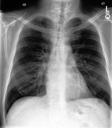
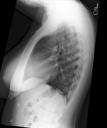
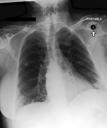
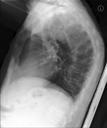
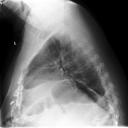

In [72]:
#splits = splits.load()
dp['split'] = dp['slice_assigned_split']
dp.head()

In [73]:
from collections import Counter
print(Counter(list(dp['split'])))

Counter({'train': 7037, 'test': 1926, 'valid': 1036})

### Train Model

In [74]:
import terra 
from vision import train
from torchvision import transforms

preprocessing = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])


dp["input"] = dp["cxr_jpg_1024"].to_lambda(preprocessing)

@terra.Task
def train_vg(dp, run_dir: str = None):

    model = train(
        config={"pretrained": True, 'transform': None, 'train_transform': None},
        dp=dp,
        input_column="input",
        max_epochs=5,
        id_column="dicom_id",
        target_column=target,
        ckpt_monitor="valid_auroc",
        batch_size=128, 
        run_dir=run_dir,
        val_check_interval=10,
        num_workers=6
    )
    return model

train_vg(dp=dp)

task: train_vg, run_id=16798


[2021-09-23 20:43:52,940][INFO][pytorch_lightning.utilities.seed:65] :: Global seed set to 123
/home/common/envs/conda/envs/domino/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/common/envs/conda/envs/domino/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Checkpoint directory /home/sabri/terra/slice/tasks/__main__/train_vg/_runs/16798 exists and is not empty.
  warnings.warn(*args, **kwargs)
[2021-09-23 20:43:53,203][INFO][pytorch_lightning.utilities.distributed:73] :: GPU available: True, used: True
[2021-09-23 20:43:53,204][INFO][pytorch_lightning.utilities.distributed:73] :: TPU available: False, using: 0 TPU cores
[2021-09-23 20:43:53,224][INFO][pytorch_lightning.accelerators.gpu:63] :: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: Currently logged 

[2021-09-23 20:44:00,197][INFO][pytorch_lightning.core.lightning:1496] :: 
  | Name        | Type       | Params
-------------------------------------------
0 | model       | ResNet     | 11.2 M
1 | metrics     | ModuleDict | 0     
2 | valid_preds | PredLogger | 0     
-------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


/home/common/envs/conda/envs/domino/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  warnings.warn(*args, **kwargs)

InvalidVersionSpec: Invalid version '0.70.11Cython>=0.29.21': invalid character(s)



len auroc 2


[2021-09-23 20:44:05,612][INFO][pytorch_lightning.utilities.seed:65] :: Global seed set to 123


len auroc 9


len auroc 9


len auroc 9


len auroc 9


len auroc 9


len auroc 9


len auroc 9


len auroc 9


len auroc 9


len auroc 9


len auroc 9


len auroc 9


len auroc 9


len auroc 9


len auroc 9


len auroc 9


len auroc 9


len auroc 9


len auroc 9


len auroc 9


len auroc 9


len auroc 9


len auroc 9


len auroc 9


len auroc 9



train_loss,0.00321
epoch,4
trainer/global_step,274
_runtime,260
_timestamp,1632430093
_step,299
valid_loss,0.56626
valid_accuracy,0.83494
valid_auroc,0.841


train_loss,█▇▅▅▆▅▅▆▃▃▃▃▃▄▃▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
valid_loss,▃▃▃▄▃▁▁▂▅▃▃▅▄▆▅▆▆▆▇▇▇████
valid_accuracy,▄▄▃▃▄█▄▇▃▂▆█▁▂▆▇▇▇█▅█▇▇▆▇
valid_auroc,▁▂▇▇██▇▆▇▄▆▄▃▃▄▄▄▄▁▅▃▅▄▅▅


Artifact(id=220732, run_id=16798, type=<class 'vision.Classifier'>)

In [79]:
run_id = 16798
dataset_dp = terra.inp(run_id)["dp"].load()
model = terra.get_artifacts(run_id, "best_chkpt")["model"]

### Score Model

In [80]:
from domino.vision import score
score_dp = score(
    model=model.load(), 
    dp=dataset_dp.lz[dataset_dp["split"] == "test"], 
    input_column="input",
    batch_size=128
)

In [81]:
score_dp["prob"] = score_dp["output"].probabilities().data[:, -1]

In [82]:
from sklearn.metrics import roc_auc_score
print("Overall AUROC: {}".format(
    roc_auc_score(score_dp[target], score_dp["prob"])
))

curr_dp = score_dp.lz[score_dp[target] == score_dp[correlate]]
print("AUROC where correlation holds: {}".format(
    roc_auc_score(curr_dp[target], curr_dp["prob"])
))

curr_dp = score_dp.lz[score_dp[target] != score_dp[correlate]]
print("AUROC where correlation does not hold: {}".format(
    roc_auc_score(curr_dp[target], curr_dp["prob"])
))

Overall AUROC: 0.8670940612828733

AUROC where correlation holds: 0.8847242451163475

AUROC where correlation does not hold: 0.6535244922341696

### Analyze with CLIP Embeddings

In [83]:
from emb.clip import embed_images
score_dp = embed_images(dp=score_dp, img_column="cxr_jpg_1024").load()

task: embed_images, run_id=16799


In [84]:
from emb.clip import embed_words, get_wiki_words
#words_dp = get_wiki_words()
#words_dp = embed_words(words_dp).load()
words_dp = embed_words.out(6537).load()
words_dp = words_dp.lz[:int(1e4)]

,cxr_jpg_1024 (ImageColumn),prob (TensorColumn),lung_group (PandasSeriesColumn),cardio_group (PandasSeriesColumn)
0,,tensor(0.2513),True,True
1,,tensor(0.3711),True,True
2,,tensor(0.0214),True,True
3,,tensor(0.0096),True,True
4,,tensor(0.2553),True,True
...,...,...,...,...
205,,tensor(0.3317),True,True
206,,tensor(0.4511),True,True
207,,tensor(0.4933),True,True
208,,tensor(0.4843),True,True

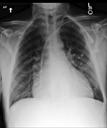
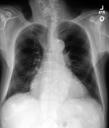
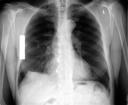
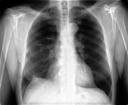
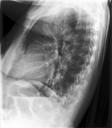
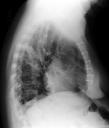
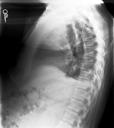
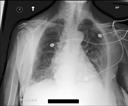
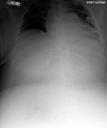
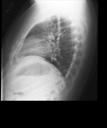

In [85]:
mk.config.DisplayOptions.max_rows = 10
error_dp = score_dp.lz[(score_dp["prob"] > 0.5).numpy() != (score_dp[target] == 1)]
error_dp = error_dp.lz[(error_dp[target] == 1)]
error_dp[["cxr_jpg_1024", "prob", target, correlate]]

In [86]:
mk.config.DisplayOptions.max_rows = 40

dp = score_dp
prob_indices = (dp["prob"] > 0.5).data.numpy().astype(bool)
attr_emb = dp.lz[prob_indices]["emb"].data.mean(axis=0) #average embedding of predicted lung images
ref_emb = dp.lz[dp[target] == 1]["emb"].data.mean(axis=0) #average embedding of true lung images

#error_1_indices = ((dp["prob"] > 0.5).data.numpy().astype(bool)) & ((dp[target] == 0).data.astype(bool))
#error_1_emb =  dp.lz[error_1_indices]["emb"].data.mean(axis=0)

#error_2_indices = ((dp["prob"] < 0.5).data.numpy().astype(bool)) & ((dp[target] == 1).data.astype(bool))
#error_2_emb =  dp.lz[error_2_indices]["emb"].data.mean(axis=0)

scores = np.dot(words_dp["emb"].data, attr_emb - ref_emb)
words_dp["score"] = scores
words_dp.lz[(-scores).argsort()[:20]]

,word (PandasSeriesColumn),frequency (PandasSeriesColumn),index (PandasSeriesColumn),tokens (LambdaColumn),emb (NumpyArrayColumn),score (NumpyArrayColumn)
0,instrumentation,14720,9795,LambdaCell(fn=),"np.ndarray(shape=(512,))",0.258545
1,programmes,47367,4136,LambdaCell(fn=),"np.ndarray(shape=(512,))",0.215576
2,circuits,18950,8226,LambdaCell(fn=),"np.ndarray(shape=(512,))",0.208740
3,patents,20319,7790,LambdaCell(fn=),"np.ndarray(shape=(512,))",0.206299
4,electrons,16851,8909,LambdaCell(fn=),"np.ndarray(shape=(512,))",0.203735
5,networks,77580,2743,LambdaCell(fn=),"np.ndarray(shape=(512,))",0.202881
6,electrical,71316,2947,LambdaCell(fn=),"np.ndarray(shape=(512,))",0.202148
7,airplay,18190,8451,LambdaCell(fn=),"np.ndarray(shape=(512,))",0.200806
8,interface,42062,4564,LambdaCell(fn=),"np.ndarray(shape=(512,))",0.192627
9,fixture,17172,8787,LambdaCell(fn=),"np.ndarray(shape=(512,))",0.186157


### Analyze with Multimodal Embeddings

In [152]:
import pickle
ckpt_dir = '/pd/maya/rx-multimodal/classifier/checkpoints/0919_clip_vit_findingsimpressions_full/'
with open(os.path.join(ckpt_dir, 'all_img_vectors.pkl'), 'rb') as f:
    keyToImgVector = pickle.load(f)
print(len(keyToImgVector))


377110

In [153]:
import pickle
ckpt_dir = '/pd/maya/rx-multimodal/classifier/checkpoints/0919_clip_vit_findingsimpressions_full/'
with open(os.path.join(ckpt_dir, 'all_rep_vectors.pkl'), 'rb') as f:
    keyToRepVector = pickle.load(f)
print(len(keyToRepVector))


89651

In [154]:
word_embs = []
keys = []
for k in keyToRepVector: 
    word_embs.append(keyToRepVector[k])
    keys.append(k)

words_dp=mk.DataPanel({'word_embs': word_embs, 'key': keys})

In [155]:
dicom_ids = list(score_dp['dicom_id'])
img_vectors = []
for d in dicom_ids:
    img_vectors.append(keyToImgVector[d])
score_dp['img_emb'] = img_vectors

In [156]:
dp = score_dp
prob_indices = (dp["prob"] > 0.5).data.numpy().astype(bool)
attr_emb = dp.lz[prob_indices]["img_emb"].data.mean(axis=0) #average embedding of predicted lung images
ref_emb = dp.lz[dp[target] == 1]["img_emb"].data.mean(axis=0) #average embedding of true lung images


#error_1_indices = ((dp["prob"] > 0.5).data.numpy().astype(bool)) & ((dp[target] == 0).data.astype(bool))
#error_1_emb =  dp.lz[list(error_1_indices)]["img_emb"].data.mean(axis=0)

#error_2_indices = ((dp["prob"] < 0.5).data.numpy().astype(bool)) & ((dp[target] == 1).data.astype(bool))
#error_2_emb =  dp.lz[list(error_2_indices)]["img_emb"].data.mean(axis=0)

In [157]:
scores = np.dot(words_dp['word_embs'].data, attr_emb - ref_emb)
words_dp["score"] = scores
words_dp.lz[(-scores).argsort()[:20]]

,word_embs (NumpyArrayColumn),key (ListColumn),index (PandasSeriesColumn),score (NumpyArrayColumn)
0,"np.ndarray(shape=(256,))","('14829515', '52483463')",55376,0.261173
1,"np.ndarray(shape=(256,))","('16335622', '55600761')",61020,0.260865
2,"np.ndarray(shape=(256,))","('10160202', '58949523')",83980,0.260726
3,"np.ndarray(shape=(256,))","('11532890', '52762182')",65862,0.260717
4,"np.ndarray(shape=(256,))","('18732946', '52017313')",26827,0.260662
5,"np.ndarray(shape=(256,))","('16522734', '54472900')",8312,0.260600
6,"np.ndarray(shape=(256,))","('17172316', '56346768')",33246,0.260531
7,"np.ndarray(shape=(256,))","('19538400', '59409378')",35288,0.260465
8,"np.ndarray(shape=(256,))","('11388341', '59174844')",8461,0.260461
9,"np.ndarray(shape=(256,))","('19538400', '59410325')",35593,0.260427


In [158]:
list(words_dp.lz[(-scores).argsort()[:20]]['key'])

[('14829515', '52483463'),
 ('16335622', '55600761'),
 ('10160202', '58949523'),
 ('11532890', '52762182'),
 ('18732946', '52017313'),
 ('16522734', '54472900'),
 ('17172316', '56346768'),
 ('19538400', '59409378'),
 ('11388341', '59174844'),
 ('19538400', '59410325'),
 ('12460718', '51975419'),
 ('13528306', '52774238'),
 ('15690303', '59926449'),
 ('18426683', '57871877'),
 ('14189828', '51869794'),
 ('17172316', '56677881'),
 ('11697323', '57604575'),
 ('17165725', '50312727'),
 ('11119242', '53454319'),
 ('19381140', '58942026')]

In [159]:
STOP_WORDS = set(
    """
a about above across after afterwards again against all almost alone along
already also although always am among amongst amount an and another any anyhow
anyone anything anyway anywhere are around as at
back be became because become becomes becoming been before beforehand behind
being below beside besides between beyond both bottom but by
call can cannot ca could
did do does doing done down due during
each eight either eleven else elsewhere empty enough even ever every
everyone everything everywhere except
few fifteen fifty first five for former formerly forty four from front full
further
get give go
had has have he hence her here hereafter hereby herein hereupon hers herself
him himself his how however hundred
i if in indeed into is it its itself
keep
last latter latterly least less
just
made make many may me meanwhile might mine more moreover most mostly move much
must my myself
name namely neither never nevertheless next nine no nobody none noone nor not
nothing now nowhere
of off often on once one only onto or other others otherwise our ours ourselves
out over own
part per perhaps please put
quite
rather re really regarding
same say see seem seemed seeming seems serious several she should show side
since six sixty so some somehow someone something sometime sometimes somewhere
still such
take ten than that the their them themselves then thence there thereafter
thereby therefore therein thereupon these they third this those though three
through throughout thru thus to together too top toward towards twelve twenty
two
under until up unless upon us used using
various very very via was we well were what whatever when whence whenever where
whereafter whereas whereby wherein whereupon wherever whether which while
whither who whoever whole whom whose why will with within without would
yet you your yours yourself yourselves
""".split()
)

MED_STOP_WORDS = ['chest', 'final', 'report', 'examination', 'examination:', 'indication', 'indication:', \
                  'technique', 'technique:', 'comparison', 'comparison:', 'findings', 'findings:', 'impression:', '___', '___.', '//']

In [26]:
from collections import Counter
import scispacy
import spacy
from scispacy.linking import EntityLinker

nlp = spacy.load("en_core_sci_sm")
nlp.add_pipe("scispacy_linker", config={"resolve_abbreviations": True, "linker_name": "umls"})

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2020-10-09/umls/tfidf_vectors_sparse.npz not found in cache, downloading to /tmp/tmpweqn5c9y
Finished download, copying /tmp/tmpweqn5c9y to cache at /root/.scispacy/datasets/e9f7327283e43f0482f7c0c71b71dec278a58ccb3ffdd03c2c2350159e7ef146.f2a350ad19015b2591545f7feeed6a6d6d2fffcd635d868a5d7fc0dfc3cadfd8.tfidf_vectors_sparse.npz
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2020-10-09/umls/nmslib_index.bin not found in cache, downloading to /tmp/tmp1fh843ys
Finished download, copying /tmp/tmp1fh843ys to cache at /root/.scispacy/datasets/f48455d6c79262057cce66b4619123c2b558b21092d42fac97f47bb99a5b8f9f.dd70d3dffe7d90d7ac8914460e16a48375dab32485fb6313a34e6fbcaf53218b.nmslib_index.bin
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2020-10-09/umls/tfidf_vectorizer.joblib not found in cache, downloading to /tmp/tmpet3pw1c2
Finished download, copying /tmp/tmpet3pw1c2 to cache at /root/.scispacy/da

/home/common/envs/conda/envs/domino/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.20.3 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/common/envs/conda/envs/domino/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.20.3 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2020-10-09/umls/concept_aliases.json not found in cache, downloading to /tmp/tmpd3nu06rj
Finished download, copying /tmp/tmpd3nu06rj to cache at /root/.scispacy/datasets/1428ec15d3b1061731ea273c03699130b3d6b90948993e74bda66af605ff8e2a.aeb7a686c654df6bccb6c2c23d3eda3eb381daaefda4592b58158d0bee53b352.concept_aliases.json
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/kbs/2020-10-09/umls_2020_aa_cat0129.jsonl not found in cache, downloading to /tmp/tmphzus5ck5
Finished download, copying /tmp/tmphzus5ck5 to cache at /root/.scispacy/datasets/4d7fb8fcae1035d1e0a47d9072b43d5a628057d35497fbfb2499b4b7b2dd4dd7.05ec7eef12f336d4666da85b7fa69b9401883a7dd4244473f7b88b413ccbba03.umls_2020_aa_cat0129.jsonl
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/umls_semantic_type_tree.tsv not found in cache, downloading to /tmp/tmp5c9oc1kd
Finished download, copying /tmp/tmp5c9oc1kd to cache at /root/.scispacy/datasets/21a1012c53

In [160]:
keys = words_dp.lz[(-scores).argsort()[:10]]['key']
all_re_words = []
for key in keys:
    path = f'p{key[0][:2]}/p{key[0]}/s{key[1]}.txt'
    report_path = os.path.join('/home/common/datasets/mimic/mimic-cxr-reports/files/', path)
    report = ''
    with open(report_path) as f:
        for line in f.readlines():
            report+=line.strip().lower()+' '
    doc = nlp(report)
    #print(doc)
    #print('---')
    print(list(doc.sents)[int(key[2])])

    words = []
    for word in report.split():
        if(word not in STOP_WORDS and word not in MED_STOP_WORDS): words.append(word)
    words = set(words)
    all_re_words.extend(list(words))

IndexError: tuple index out of range

In [161]:
report_path = '/pd/maya/rx-multimodal/classifier/datasets/mimic_cxr_sectioned.csv'
import csv
all_reports = {}
with open(report_path, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        all_reports[row['study']] = {}
        all_reports[row['study']]['findings'] = row['findings']
        all_reports[row['study']]['impression'] = row['impression']
print(len(all_reports))

227781

In [162]:
keys = words_dp.lz[(-scores).argsort()[:10]]['key']
all_re_words = []
for key in keys:
    path = f's{key[1]}'
    report = all_reports[path]['findings']
    doc = nlp(report)
    print(doc)
    print('---')
    #print(list(doc.sents)[int(key[2])])

    words = []
    for word in report.split():
        if(word.lower() not in STOP_WORDS and word.lower() not in MED_STOP_WORDS): 
            if(word[-1]=='.'): word = word[:-1]
            words.append(word.lower().strip())
    #words = set(words)
    all_re_words.extend(list(words))

There are 2 left chest tubes.  Right PICC line tip is near cavoatrial
 junction.  Heart is enlarged.  Pulmonary edema has improved.  Stable left
 basilar consolidation.  Small left pleural effusion, stable.  No pneumothorax.
 Stable postoperative changes.

---

Compared with ___ just after midnight, the right IJ catheter has been
 removed. No pneumothorax is detected. Again seen is a left IJ catheter with
 tip at the expected confluence of the brachiocephalic vein and SVC.
 
 Otherwise, I doubt significant interval change. Again seen is cardiomegaly,
 pulmonary edema, bilateral effusions, and underlying collapse and/or
 consolidation. Right midzone lateral calcified granuloma again noted.

---

As compared to prior chest radiograph from ___, there has
 been interval placement of an ET and OG tube.  Endotracheal tube terminates
 5.9 cm above the carina.  The orogastric tube is difficult to visualize,
 however the tip is likely in the proximal stomach.  There has been interval
 improvement of bilateral consolidations, likely related to resolving pulmonary
 edema.  There are small bilateral pleural effusions.  There is atelectasis at
 the left lung base. There is redemonstration of elevation of the left
 hemidiaphragm, which appears chronic in nature. Cardiomegaly is unchanged.

---

The endotracheal tube terminates 5.3 cm above the carinal. Two transesophageal
 catheters are present.  A right IJ catheter terminates at the mid to upper
 SVC. There has been interval removal of a left central venous catheter.
 Central pulmonary vascular congestion and mild pulmonary edema are unchanged
 since ___. Moderate right and small left pleural effusions have
 slightly enlarged.

---

The tip of the endotracheal tube projects at the level of the clavicular
 heads, 6.7 cm from the carina and could be advanced.  The feeding tube extends
 into the stomach.  The tip of the right PICC line projects over the cavoatrial
 junction.
 
 Low bilateral lung volumes with unchanged pulmonary edema, and bilateral
 layering pleural effusions with subjacent atelectasis.  No pneumothorax
 identified.
 
 The size the cardiac silhouette is enlarged but unchanged.

---

Rotated positioning.  Right-sided Port-A-Cath tip lies near the cavoatrial
 junction.  2 separate tubes overlie the right lung base, similar to prior.
 
 The possibility of a small residual right apical pneumothorax cannot be
 excluded.  The prior study raise the possibility that there was fluid
 associated with the pleural space in this area.  Subcutaneous emphysema in the
 right supraclavicular fossae, extending into the right lower neck, is similar
 to the prior film.
 
 There is cardiomegaly, similar to prior.  The previous right cardiophrenic
 opacity has improved.  A small right pleural effusion  is now visible. 
 Ppacity Retrocardiac opacity is again seen, slightly more pronounced.  Doubt
 CHF.

---

The support apparatus are unchanged and in standard position.  Bilateral
 pigtail catheters are again seen.
 There has been interval worsening of the interstitial pulmonary edema and
 layering pleural effusions.  The cardiomediastinal silhouette these compare
 above.  No pneumothorax.

---

Right PICC line tip in the low SVC.  Enteric tube tip is in the mid stomach. 
 There are bilateral pleural effusions, which have mildly increased since prior
 exam.  There is left lower lobe consolidation, which is stable.  Increased
 heart size, pulmonary vascularity.  There are bilateral central, basilar
 pulmonary opacities, favor edema, consider pneumonitis, less likely ARDS. 
 Surgical clips in the upper abdomen.

---

The tip of the endotracheal tube projects over the mid thoracic trachea.  A
 gastric tube extends below the level the diaphragms.  A left central venous
 catheter tip again projects over the lower right atrium.
 
 No significant interval change in the appearance of the lungs given
 differences in technique.  Persisting bilateral pleural effusions with
 overlying atelectasis and pulmonary edema.  The size of the cardiac silhouette
 is enlarged but unchanged.

---

Feeding tube tip in the proximal stomach.  Right PICC line tip in the low SVC.
 Stable left lower lobe consolidation.  Increased heart size, pulmonary
 vascularity, similar.  Interstitial prominence, likely edema, improved.  Mild
 area of right midlung opacity has improved.  Decreased right basilar opacity. 
 Decreased left and probably stable right pleural effusion.  Surgical clips
 upper abdomen.

---

In [124]:
Counter(all_re_words).most_common(40)

[('right', 18),
 ('left', 12),
 ('tip', 12),
 ('pulmonary', 11),
 ('pleural', 10),
 ('tube', 10),
 ('bilateral', 9),
 ('stable', 6),
 ('interval', 6),
 ('prior', 6),
 ('unchanged', 6),
 ('edema', 5),
 ('small', 5),
 ('pneumothorax', 5),
 ('catheter', 5),
 ('effusions', 5),
 ('picc', 4),
 ('line', 4),
 ('enlarged', 4),
 ('improved', 4),
 ('svc', 4),
 ('edema,', 4),
 ('endotracheal', 4),
 ('likely', 4),
 ('stomach', 4),
 ('projects', 4),
 ('similar', 4),
 ('lower', 4),
 ('opacity', 4),
 ('cavoatrial', 3),
 ('junction', 3),
 ('heart', 3),
 ('basilar', 3),
 ('consolidation', 3),
 ('ij', 3),
 ('seen', 3),
 ('terminates', 3),
 ('cm', 3),
 ('atelectasis', 3),
 ('lung', 3)]

### scratch (ignore following code)

In [104]:
attr_words = Counter(all_re_words)

In [109]:
ref_words = Counter(all_re_words)

In [119]:
counts = {}
for word in attr_words:
    c = attr_words[word]
    if(word in ref_words): c -= ref_words[word]
    counts[word] = c
print({k: v for k, v in sorted(counts.items(), key=lambda item: -item[1])})

{
    'left': 16,
    'effusion.': 8,
    'tube': 8,
    'likely': 6,
    'atelectasis': 5,
    '1.': 5,
    '2.': 5,
    'tip': 5,
    'chest.': 4,
    'radiograph': 4,
    'mild': 4,
    'vascular': 4,
    'new': 4,
    'pneumonia': 4,
    'position.': 4,
    'elevation': 4,
    'hemidiaphragm': 4,
    'greater': 4,
    'pleural': 3,
    'post': 3,
    'heart': 3,
    'small': 3,
    'basilar': 3,
    'opacity,': 3,
    'history:': 3,
    'congestion': 3,
    'hypoinflated': 3,
    'lungs': 3,
    'lines': 3,
    'frontal': 3,
    'enteric': 3,
    'unremarkable.': 3,
    'status': 3,
    'picc': 3,
    'focal': 3,
    'hemidiaphragm.': 3,
    'atrium.': 3,
    'recent': 3,
    'size,': 2,
    'suggestion': 2,
    'effusion,': 2,
    'similar.': 2,
    'mildly': 2,
    'atelectasis,': 2,
    'thoracic': 2,
    'remains': 2,
    'right,': 2,
    'bibasilar': 2,
    'lower': 2,
    'lobe': 2,
    'represents': 2,
    'appropriate': 2,
    '3.': 2,
    'support': 2,
    'tubes': 2,
    'described': 2,
    'above.': 2,
    '___,': 2,
    'coursing': 2,
    'mid': 2,
    'level': 2,
    'perihilar': 2,
    'given': 2,
    'exaggerate': 2,
    'altered': 2,
    'mental': 2,
    'ends': 2,
    'stomach.': 2,
    'svc.': 2,
    'consolidation.': 2,
    'placement.': 2,
    'low': 2,
    'appears': 2,
    'significant': 2,
    'volume': 2,
    'loss': 2,
    'addendum': 2,
    '___-year-old': 2,
    'combination': 2,
    'exam.': 2,
    'placement': 2,
    'left,': 2,
    'pneumoperitoneum,': 2,
    'gastrostomy': 2,
    'increased': 2,
    'border': 2,
    'lung,': 2,
    'obscuration': 2,
    'vs': 2,
    'pcnl,': 1,
    'second': 1,
    'stage': 1,
    'pcnl': 1,
    'assess': 1,
    'recurrent': 1,
    'effusion;': 1,
    'seat': 1,
    'patient': 1,
    'view': 1,
    'shallow': 1,
    'inspiration': 1,
    'accentuates': 1,
    'pulmonary': 1,
    'vascularity.': 1,
    'tube.': 1,
    'worsened': 1,
    'come': 1,
    'additional': 1,
    'tubing': 1,
    'projected': 1,
    'quadrant.': 1,
    'worsened.': 1,
    'silhouette': 1,
    'size': 1,
    'normal.': 1,
    'contour': 1,
    'atherosclerotic': 1,
    'calcification': 1,
    'noted': 1,
    'aorta.': 1,
    'position,': 1,
    'pneumothorax': 1,
    'demonstrated.': 1,
    'streaky': 1,
    'bases,': 1,
    'pronounced': 1,
    'reflect': 1,
    'cephalization': 1,
    'vasculature.': 1,
    'congestion.': 1,
    '1:31': 1,
    'setting.': 1,
    '______________________________________________________________________________': 1,
    '___f': 1,
    'intubation.': 1,
    'supine': 1,
    'radiograph.': 1,
    'feeding': 1,
    'field': 1,
    'view.': 1,
    'clavicles,': 1,
    '1.9': 1,
    'carina': 1,
    'intact': 1,
    'wires.': 1,
    'interstitial': 1,
    'cephalization.': 1,
    'heterogeneous': 1,
    'opacity.': 1,
    'contour,': 1,
    'hila': 1,
    'probable': 1,
    'cough.': 1,
    'origin': 1,
    'mare': 1,
    'apex': 1,
    'suggests': 1,
    'subpulmonic': 1,
    'increase': 1,
    'epilepticus,': 1,
    'intubated.': 1,
    'volumes': 1,
    'difficult': 1,
    'reliably': 1,
    'discern,': 1,
    'probably': 1,
    'hemi': 1,
    'platelike': 1,
    'lingular': 1,
    'assess.': 1,
    'looped': 1,
    'right-sided': 1,
    'positioning': 1,
    'ett.': 1,
    'volumes.': 1,
    'thorax,': 1,
    'collapse': 1,
    'middle': 1,
    'context,': 1,
    'evaluation': 1,
    'difficult.': 1,
    'request': 1,
    'attempt': 1,
    'location': 1,
    'catheter.': 1,
    'review,': 1,
    'catheter': 1,
    'best': 1,
    'view,': 1,
    'confirmed': 1,
    'female': 1,
    'pain.': 1,
    'prior,': 1,
    'dense': 1,
    'obscuring': 1,
    'consolidation,': 1,
    'hiatal': 1,
    'hernia': 1,
    'suspected.': 1,
    '2': 1,
    'separate': 1,
    'subclavian': 1,
    'identified': 1,
    'larger': 1,
    'terminating': 1,
    'smaller': 1,
    'clearly': 1,
    'delineated': 1,
    'current': 1,
    'degenerative': 1,
    'changes': 1,
    'spi

In [ ]:
keys = words_dp.lz[(-scores).argsort()[:10]]['key']
all_re_words = []
for key in keys:
    path = f'p{key[0][:2]}/p{key[0]}/s{key[1]}.txt'
    report_path = os.path.join('/home/common/datasets/mimic/mimic-cxr-reports/files/', path)
    report = ''
    with open(report_path) as f:
        for line in f.readlines():
            report+=line.strip().lower()+' '
    doc = nlp(report)
    #print(doc)
    words = [str(x) for x in doc.ents]
    #print(words)
    linker = nlp.get_pipe("scispacy_linker")
    ent_names = []
    for ent in doc.ents:
        if(ent in STOP_WORDS or ent in MED_STOP_WORDS): continue
        for umls_ent in ent._.kb_ents:
            a = linker.kb.cui_to_entity[umls_ent[0]]
            ent_names.append(a[1])
            break
    #print(ent_names)
    for word in ent_names:
        all_re_words.append(word)
    #all_re_words.extend(list(words))

In [81]:
Counter(all_re_words).most_common(20)

[('Comparison', 17),
 ('effusion', 16),
 ('Pleural effusion disorder', 15),
 ('No status change', 14),
 ('findings aspects', 10),
 ('Indication of (contextual qualifier)', 9),
 ('Clinical Research', 9),
 ('Cardiomegaly', 9),
 ('Pneumothorax', 8),
 ('Lung consolidation', 8),
 ('impression (attitude)', 7),
 ('Pulmonary Edema', 7),
 ('Bilateral', 7),
 ('year', 6),
 ('Congestive heart failure', 6),
 ('Post', 5),
 ('Sternotomy (procedure)', 5),
 ('Stable status', 5),
 ('Edema', 5),
 ('KAT5 wt Allele', 5)]